# Mod 3 Final Project

## Student Info

- Name: Andi Osika
- Cohort: ptds_100719
- Instructor: James Irving, PhD


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

In [1]:
# !pip install -U fsds_100719
# from fsds_100719.imports import *

import pandas as pd


In [2]:
import functions as fn

## Uncomment the line below to see the source code for the imported functions
# fs.ihelp(Cohen_d,False),fs.ihelp(find_outliers_IQR,False), fs.ihelp(find_outliers_Z,False)

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

# List of Tables:

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [5]:
cur.execute("""SELECT * FROM `Order`;""")
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
df.head()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [6]:
## looking at dates to get an idea of timeframe
df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [7]:
df['OrderDate'].describe()

count                     830
unique                    480
top       2014-02-26 00:00:00
freq                        6
first     2012-07-04 00:00:00
last      2014-05-06 00:00:00
Name: OrderDate, dtype: object

Timespan is ~ 2 years : April 7 2012 - June 5 2014

# HYPOTHESIS 1

> ***Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?***

- $H_0$:There is no statistcally significant effect on the quantity of a product in an order in relation to a discount amount.
- $H_1$:Discounts have a statistically significant effect on the quantiy of a product in an order.
- $H_1a$:Certain discount values have a greater effect than others.

## Importing and inspecting data from OrderDetail table:

This table includes order information on:

    1) Quantity
    2) Discount 

Will use the mean of the aggregate data of quantity ordered in comparison with orders where discounts were involved.

In [8]:
cur.execute("""SELECT * FROM OrderDetail;""")
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
#explorting dataset
specs = df.describe()
specs

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


General Observation: Pricing ranges from `$2` - `$263` with an average price of `$26.21` and average qty of 23 items ordered, no null values

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [12]:
len(df['OrderId'].unique())

830

### Initial Visual Inspection:

From this dataset of 2155 orders, the average quantity ordered is 24 regardless of discount, the minimum ordered is 0 and max ordered is 130, although the IQR is between 10 and 30.

In [15]:
qty = df['Quantity']
qty_specs = qty.describe()
qty_specs

count    2155.000000
mean       23.812993
std        19.022047
min         1.000000
25%        10.000000
50%        20.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [16]:
qty_mu = round(qty_specs['mean'],0)
n = len(df)
print(f'The average quantity ordered from this sample is : {qty_mu}')
print(f'There are {n} orders in this sample.')

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample.


In [17]:
d =list(df['Discount'].unique())
d
#Dscounts are as follows:

[0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01]

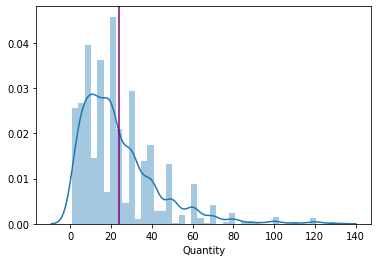

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(qty)
plt.axvline(qty_mu, label='Qty Mean', color='purple')
plt.show()


In [21]:
import seaborn as sns
from ipywidgets import interact

In [22]:

@interact
def plt_discounts(d=d):
    sns.distplot(df.groupby('Discount').get_group(d)['Quantity'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=(0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.…

In [23]:
dfa = df.groupby('Discount').count()['Quantity']
display(dfa)


Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Quantity, dtype: int64

**The sample sizes associated with discounts .01, .02, .03, .04 and .06 are relatively nominal <3, and will be dropped since this makes it difficult to evaulate their impact in comparison with the other groups.**

In [24]:
discs = {}
for disc in df['Discount'].unique():
    discs[disc] = df.groupby('Discount').get_group(disc)['Quantity']

In [25]:
for k,v in discs.items():
    print(k)

0.0
0.15
0.05
0.2
0.25
0.1
0.02
0.03
0.04
0.06
0.01


In [28]:
l=[.01,.02,.03,.04,.06]
oneper = discs.pop(.01)
twoper = discs.pop(.02)
threeper = discs.pop(.03)
fourper = discs.pop(.04)
sixper = discs.pop(.06)

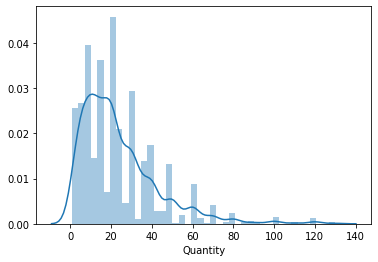

In [29]:
sns.distplot(df['Quantity'])

Distributions appear roughly equal,


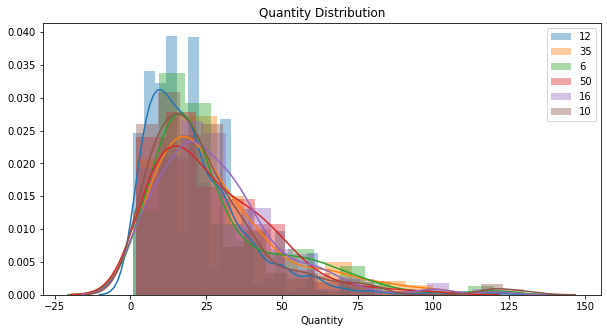

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in discs.items():
    sns.distplot(v,label=v)

plt.title('Quantity Distribution')
plt.legend()
print('Distributions appear roughly equal,')

## Initial Observations:

Datatype is numeric.  

The average quantity ordered from this sample is : 24.0
There are 2155 orders in this sample. 

Discounts are as follows:
0.0, 0.15, 0.05, 0.2, 0.25, 0.1, 0.02, 0.03, 0.04, 0.06, 0.01

The majority of product purchases are without the discount(1317/2155) 61%, and frequency of discounts are as follows:
5%
10%
20%
15%
25%

For discounts 1%,2%,3%,4%, and 6% , the amount of data provided was relatively small to evaluate the impact on the whole.  This data was removed from further testing.

Overall distributions appears relatively uniform. 

### Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA or Kruksal test will be run depending on how assumptions are met: 
   
    
Assumptions for ANOVA Testing: 
(see corresponding sections

1) No significant outliers 
    * Upon a quick visual inspection, the distribution is skewed and visually there appears to be some outliers

2) Equal variance
    * Lavene's testing demonstrates NOT equal variance


3) Normality (if n>15)
      * Not required for discounts: 5%, 10%, 15%, 20% and 25% since n > 15




### Assumption 1:  Outliers 

Evaluation and removal via Z-Score testing:


In [32]:
for disc, disc_data in discs.items():
    idx_outs = fn.find_outliers_Z(disc_data)
    print(f'Found {idx_outs.sum()} outliers in Discount Group {disc}')
    discs[disc] = disc_data[~idx_outs]
print('\n All of these outliers were removed')

Found 20 outliers in Discount Group 0.0
Found 2 outliers in Discount Group 0.15
Found 3 outliers in Discount Group 0.05
Found 2 outliers in Discount Group 0.2
Found 3 outliers in Discount Group 0.25
Found 3 outliers in Discount Group 0.1

 All of these outliers were removed


### Assumption 2: Equal Variance

Levines testing conducted on cleaned dataset


In [33]:
#preparing data for levene's testing
datad = []
for k,v in discs.items():
    datad.append(v)

In [34]:
import scipy.stats as stats
stat,p = stats.levene(*datad)
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')


Lavene test for equal variance results are 0.0003
The groups do NOT have equal variance


#### Since group does not prove to be equal variance, a **kruksal** will be conducted.
Looking at sample sizes to determine if normality needs to be tested.

### Assumption 3: Normality

First, checking sample sizes since assumption for normality depends on sample size. If 2-9 groups, each group n >= 15

For Discounts of 5%, 10%, 15%, 20% and 25% n>15 

In [35]:
n = []
for disc, disc_data in discs.items():
    print(f'There are {len(disc_data)} samples in the {disc} discount group.')    
    n.append(len(disc_data)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')


There are 1297 samples in the 0.0 discount group.
There are 155 samples in the 0.15 discount group.
There are 182 samples in the 0.05 discount group.
There are 159 samples in the 0.2 discount group.
There are 151 samples in the 0.25 discount group.
There are 170 samples in the 0.1 discount group.

All samples are >15: Normality Assumption Criterion is met.


## Kruksal Testing:

In [36]:
stat, p = stats.kruskal(*datad)
print(f"Kruskal test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')
    

Kruskal test p value: 0.0
Reject the null hypothesis


### ANOVA Testing for fun

In [37]:
stat, p = stats.f_oneway(*datad)
print(f"ANOVA test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')


ANOVA test p value: 0.0
Reject the null hypothesis


### Post-Hoc Testing: 

In [38]:
def prep_data_for_tukeys(reps):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()"""
    import pandas as pd
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  reps.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey,grp_df],axis=0)
        df_tukey['group']=df_tukey['group'].astype(str)
        df_tukey['data']=df_tukey['data'].astype(float)
    return df_tukey

In [39]:
disc_df = fn.prep_data_for_tukeys(discs)
disc_df

,data,group
0,12.0,0.0
1,10.0,0.0
2,5.0,0.0
3,9.0,0.0
4,40.0,0.0
...,...,...
2095,30.0,0.1
2096,77.0,0.1
2098,25.0,0.1
2099,4.0,0.1


In [40]:
disc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2114 entries, 0 to 2135
Data columns (total 2 columns):
data     2114 non-null float64
group    2114 non-null object
dtypes: float64(1), object(1)
memory usage: 49.5+ KB


In [48]:
disc_df['data']=disc_df['data'].astype(float)
disc_df['group']=disc_df['group'].astype(float)

In [49]:
disc_df.dtypes

data     float64
group    float64
dtype: object

In [50]:
d =list(disc_df['group'].unique())
d

[0.0, 0.15, 0.05, 0.2, 0.25, 0.1]

In [ ]:
for k,v in discs.items():

In [51]:
import statsmodels.api as sms


In [52]:
tukey = sms.stats.multicomp.pairwise_tukeyhsd(disc_df['data'],disc_df['group'])
tukey.summary()



group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.05,6.0639,0.001,2.4368,9.691,True
0.0,0.1,2.9654,0.2098,-0.7723,6.7031,False
0.0,0.15,6.9176,0.001,3.0233,10.8119,True
0.0,0.2,5.6293,0.001,1.7791,9.4796,True
0.0,0.25,6.1416,0.001,2.2016,10.0817,True
0.05,0.1,-3.0985,0.4621,-7.9861,1.789,False
0.05,0.15,0.8537,0.9,-4.1547,5.862,False
0.05,0.2,-0.4346,0.9,-5.4088,4.5396,False
0.05,0.25,0.0777,0.9,-4.9663,5.1218,False
0.1,0.15,3.9522,0.2311,-1.1368,9.0412,False


In [53]:

@interact
def plt_discounts(d=d):
    sns.distplot(disc_df.groupby('group').get_group(d)['data'])
    plt.axvline(qty_mu, color='purple')
    

interactive(children=(Dropdown(description='d', options=(0.0, 0.15, 0.05, 0.2, 0.25, 0.1), value=0.0), Output(…

There is a statistically significant effect on quantity purchased based on discount: The following discounts are statistically consiered equal:



In [56]:
disc_df['group']=disc_df['group'].astype(str)

In [206]:
for k,v in discs.items():
    print(f'The average quantity sold for {k} discount is {round(v.mean())}')

The average quantity sold for 0.0 discount is 21.0
The average quantity sold for 0.15 discount is 27.0
The average quantity sold for 0.05 discount is 27.0
The average quantity sold for 0.2 discount is 26.0
The average quantity sold for 0.25 discount is 27.0
The average quantity sold for 0.1 discount is 24.0


In [57]:
stats = disc_df['data'].describe()
dataqty = stats['mean']
print(f'Revised average quantity sold across all orders {round(dataqty)}')
zeros = disc_df.groupby('group').get_group('0.0')['data']
nodiscav = zeros.mean()
print(f'Average quantity sold for orders where no discount was extended was: {round(nodiscav)}')

Revised average quantity sold across all orders 23.0
Average quantity sold for orders where no discount was extended was: 21.0


In [58]:
data_mu = disc_df['data'].mean()
data_mu

22.670293282876063

In [61]:
disc_df['group']=disc_df['group'].astype(float)

### Various EDA to understand distributions and potential outliers

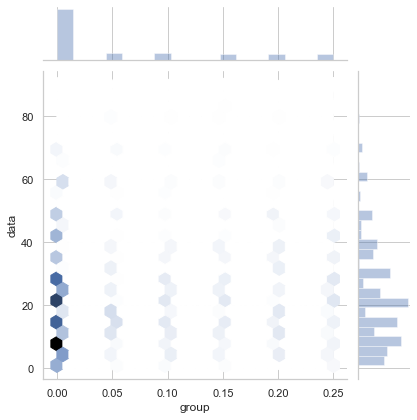

In [160]:
sns.jointplot(data=disc_df, x='group', y='data', kind='hex')

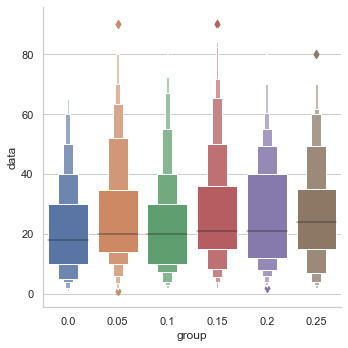

In [210]:


sns.catplot(data=disc_df, x='group', y='data', kind='boxen')
ax.axhline(26.75, color='k')
plt.gca()
plt.show()

Text(0, 0.5, 'Average Quantity Purchased')

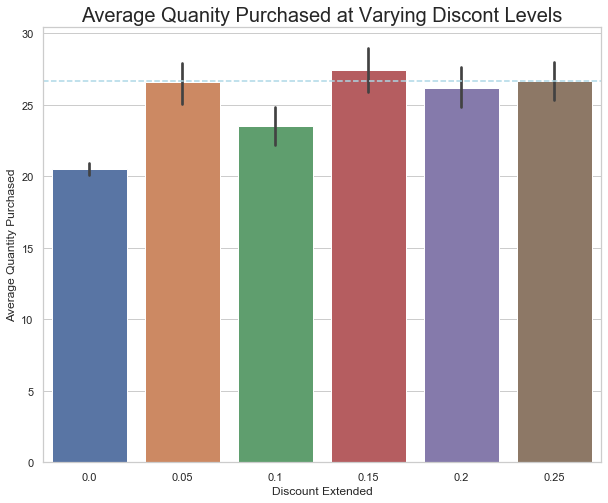

In [208]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=disc_df, x='group', y='data', ci=68)
#plt.axhline(data_mu, linestyle='--', color='gray')
plt.axhline(26.75, linestyle='--', color='lightblue')
plt.title('Average Quanity Purchased at Varying Discont Levels', fontsize=20)
plt.xlabel('Discount Extended')
plt.ylabel('Average Quantity Purchased')

In [67]:
for disc, disc_data in discs.items():
    es = fn.Cohen_d(zeros, disc_data)
    print(f'The effect size for {disc} is {round(np.abs(es),4)}')

The effect size for 0.0 is 0.0
The effect size for 0.15 is 0.453
The effect size for 0.05 is 0.3949
The effect size for 0.2 is 0.3751
The effect size for 0.25 is 0.4109
The effect size for 0.1 is 0.1982


## Hypothesis 1 Findings and Recommendation:

### Findings:
Rejecting the null hypothesis that discounts held no bearing over quantity sold. 


Some discounts that were extened provided too little data in comparison to the other groups to properly evaluate their effects on quantity sold, and those were not further examined.

With additional outliers removed for each of the discount groups, the revised average qty purchased was 23.

A 10% discount had no statistical significance on the quantiy purchased.

Discounts extended at 5%, 15%, 20%, and 25% statistically are equal in terms of their effect on quantity sold when compared to none offered, with a p-value of .001.  Each have varying effect sizes in compared to orders placed with no discount extended.
 
Discount |AvQty | Effect Size | Effect
 -- | -- | -- | --|
5 % | 27| .1982 | Small
15 % | 27| .454 | Medium
20 % |26| .3751 | Medium
25 % |27 | .454 | Medium


 
###  Recommendation:

While larger discounts did deomonstrate significant effect on quantity purchased, smaller discounts held a statistically equal effect.  To recognize the effect of driving higher quantities purchased and realize larger profit margins, offer the smaller discount.


# HYPOTHESIS 2:

> ***Do some categories generate more money than others ??*** 
  **Which ones?**
 
 


- $𝐻0$ : All categories generate equal revenues.
- $𝐻1$ : Certain categories sell at statistically higher rates of revneu than others.
- $𝐻1𝑎$ : 

### Importing and inspecting data from Product and OrderDetail tables:

These tables includes product information data including:

1) Categories 

2) Pricing and discount information to generate revenues


In [232]:
##clean sql notation
cur.execute("""SELECT 
                ProductId, 
                ProductName, 
                od.UnitPrice,
                CategoryID, 
                CategoryName, 
                Discount, 
                Quantity
                FROM Product AS p
                JOIN OrderDetail as od
                ON p.ID = Od.ProductId
                JOIN Category as c 
                ON c.ID = p.CategoryID;""")
catavs = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
catavs.head()

,ProductId,ProductName,UnitPrice,CategoryId,CategoryName,Discount,Quantity
0,11,Queso Cabrales,14.0,4,Dairy Products,0.0,12
1,42,Singaporean Hokkien Fried Mee,9.8,5,Grains/Cereals,0.0,10
2,72,Mozzarella di Giovanni,34.8,4,Dairy Products,0.0,5
3,14,Tofu,18.6,7,Produce,0.0,9
4,51,Manjimup Dried Apples,42.4,7,Produce,0.0,40


In [233]:
#Revenue is calculated by subtracting discounts from the UnitPrice and multiplying by quantity ordered.
catavs['Revenue'] = (catavs['UnitPrice'] * (1 - catavs['Discount']))*catavs['Quantity']

In [234]:
avcrev = catavs['Revenue'].mean()
print (round(avcrev),2)
cg = catavs['CategoryName'].unique()




587.0 2


### Initial Visual Inspection and Observations:

There are 8 different categories sold in this company that represent 77 products.

The average revenue generated across all categories is `$587.00`

Visually, it appears that there are three categories that significantly generate higher revenues than others, additional testing will demonstrate their siginficance and effect.


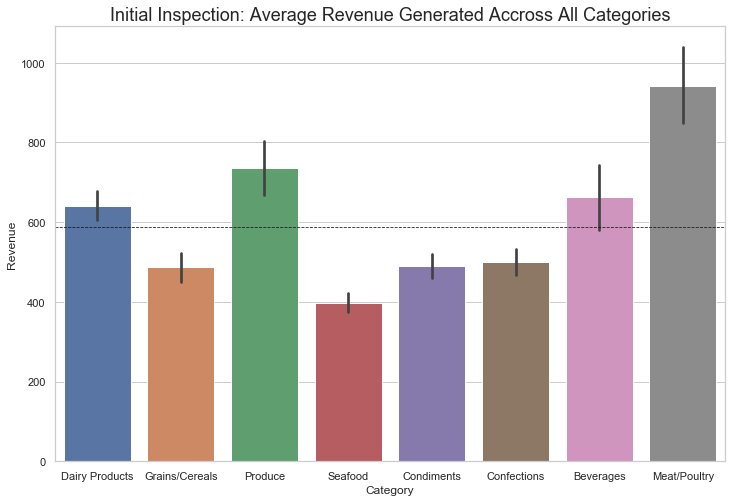

In [235]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=catavs, x='CategoryName', y='Revenue', ci=68, ax=ax)
plt.title('Initial Inspection: Average Revenue Generated Accross All Categories', fontsize=18)
plt.axhline(avcrev,linestyle="--", color='k', linewidth=.8 )
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.show()

In [236]:
catcount = len(catavs['CategoryId'].unique())
avrev = catavs['Revenue'].mean()
print(f'There are {catcount} different categories sold in this company')
print(f'The average revenue generated accross all categories is {round(avcrev,0)}')

There are 8 different categories sold in this company
The average revenue generated accross all categories is 587.0


In [237]:
cats = {}
for cat in catavs['CategoryName'].unique():
    cats[cat] = catavs.groupby('CategoryName').get_group(cat)['Revenue']

### Assumption 1: Outliers
Outliers removed via z-score testing.

In [238]:
for cat, cat_data in cats.items():
    idx_outs = fn.find_outliers_Z(cat_data)
    print(f'Found {idx_outs.sum()} outliers in Category # {cat}')
    cats[cat] = cat_data[~idx_outs]
print('\n All of these outliers were removed')

Found 5 outliers in Category # Dairy Products
Found 6 outliers in Category # Grains/Cereals
Found 1 outliers in Category # Produce
Found 8 outliers in Category # Seafood
Found 4 outliers in Category # Condiments
Found 9 outliers in Category # Confections
Found 12 outliers in Category # Beverages
Found 4 outliers in Category # Meat/Poultry

 All of these outliers were removed


In [239]:
pids = catavs['ProductName'].unique()
pids
print(f'There are {len(pids)} products')

There are 77 products


### Assumption 2: Equal Variance

Testing cleaned dataset for equal variance.

Since the groups do NOT have euqal variance, a Kruksal test will be conducted.

In [221]:
datac = []
for k,v in cats.items():
    datac.append(v)

In [240]:
import scipy.stats as stats
stat,p = stats.levene(*datac)
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')

Lavene test for equal variance results are 0.0
The groups do NOT have equal variance


### Assumption 3: Normality

All groups are > 15 samples = Assumption for normality is met.

In [241]:
n = []

for cat, cat_data in cats.items():
    print(f'There are {len(cat_data)} samples in the data set for Employee #{cat}.')
    n.append(len(cat_data)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')




There are 361 samples in the data set for Employee #Dairy Products.
There are 190 samples in the data set for Employee #Grains/Cereals.
There are 135 samples in the data set for Employee #Produce.
There are 322 samples in the data set for Employee #Seafood.
There are 212 samples in the data set for Employee #Condiments.
There are 325 samples in the data set for Employee #Confections.
There are 392 samples in the data set for Employee #Beverages.
There are 169 samples in the data set for Employee #Meat/Poultry.

All samples are >15: Normality Assumption Criterion is met.


### Kruksal Testing:

Results, reject the null hypothesis.

In [242]:
stat, p = stats.kruskal(*datac)
print(f"Kruskal test p value: {round(p,4)}")
if p < .05 :
    print(f'Reject the null hypothesis')
else: 
    print(f'Null hypotheis remains true')

Kruskal test p value: 0.0
Reject the null hypothesis


Visually inspecting:

### Post-Hoc Testing: 

In [243]:
cat_df = prep_data_for_tukeys(cats)
cat_df

,data,group
0,168.00,Dairy Products
2,174.00,Dairy Products
12,47.50,Dairy Products
13,1088.00,Dairy Products
14,200.00,Dairy Products
...,...,...
2096,2702.70,Meat/Poultry
2098,738.00,Meat/Poultry
2099,86.40,Meat/Poultry
2102,111.75,Meat/Poultry


In [244]:
catstats = cat_df['data'].describe()
catav = catstats['mean']
## need avrev for 2,3,5 and 1,8 based on Tukey



#### Visual Inspection Post Data Cleaning:

In [245]:

@interact
def plt_discounts(d=cg):
    sns.distplot(catavs.groupby('CategoryName').get_group(d)['Revenue'])
    plt.axvline(catav, color='purple')
    plt.title('Average Revenue Generated by Category')
    plt.ylabel('Disstribution')

interactive(children=(Dropdown(description='d', options=('Dairy Products', 'Grains/Cereals', 'Produce', 'Seafo…

In [246]:
tukeyc = sms.stats.multicomp.pairwise_tukeyhsd(cat_df['data'],cat_df['group'])
tukeyc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Beverages,Condiments,55.7712,0.9,-78.858,190.4005,False
Beverages,Confections,27.0669,0.9,-91.4026,145.5364,False
Beverages,Dairy Products,194.0913,0.001,78.8965,309.286,True
Beverages,Grains/Cereals,21.4034,0.9,-118.1928,160.9996,False
Beverages,Meat/Poultry,411.042,0.001,265.7215,556.3625,True
Beverages,Produce,296.1055,0.001,138.516,453.695,True
Beverages,Seafood,-46.1557,0.9,-164.9266,72.6151,False
Condiments,Confections,-28.7043,0.9,-168.1193,110.7106,False
Condiments,Dairy Products,138.32,0.0449,1.6769,274.9631,True
Condiments,Grains/Cereals,-34.3678,0.9,-192.129,123.3933,False


In [231]:
import functions as fn

In [247]:
for cat, cat_data in cats.items():
    print(f'The average revenue for {cat} is ${round(cat_data.mean(),2)}')

The average revenue for Dairy Products is $593.86
The average revenue for Grains/Cereals is $421.17
The average revenue for Produce is $695.87
The average revenue for Seafood is $353.61
The average revenue for Condiments is $455.54
The average revenue for Confections is $426.83
The average revenue for Beverages is $399.77
The average revenue for Meat/Poultry is $810.81


In [89]:
cond = cat_df.groupby('group').get_group('Condiments')
conf = cat_df.groupby('group').get_group('Confections')
gc = cat_df.groupby('group').get_group('Grains/Cereals')

seg2 = pd.concat([cond, conf, gc])
seg2av = seg2.mean()
seg2av

data    433.722693
dtype: float64

In [90]:
bev = cat_df.groupby('group').get_group('Beverages')
sea = cat_df.groupby('group').get_group('Seafood')


seg1 = pd.concat([sea, bev])
seg1av = seg1.mean()
seg1av

data    378.950151
dtype: float64

### Hypothesis 2: A Clean Vizualization

In [256]:
ax = cat_df.plot(kind='barh',x='data', y='group' ,figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

TypeError: no numeric data to plot

Text(0.5, 1.0, 'Average Revenue Generated By Category')

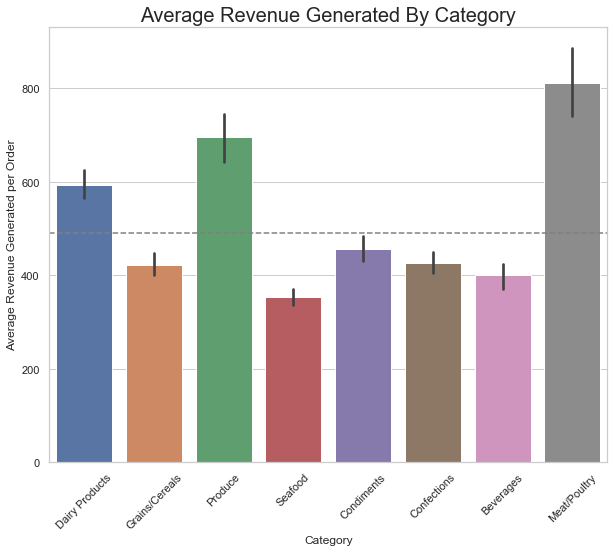

In [248]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(data=cat_df, x='group', y='data', ci=68)
plt.axhline(catav, linestyle='--', color='gray')
#plt.axhline(seg1av)
#plt.axhline(seg2av)
plt.ylabel('Average Revenue Generated per Order')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.title('Average Revenue Generated By Category', fontsize=20)


In [92]:
## Meat/Poultry Effect Size against aggregate data:
mp = cat_df.groupby('group').get_group('Meat/Poultry')
np.abs(fn.Cohen_d(cat_df['data'], mp['data']))

0.55734861900002

In [93]:
## Produce Effect Size against aggregate data:
pdc = cat_df.groupby('group').get_group('Produce')
np.abs(fn.Cohen_d(cat_df['data'], pdc['data']))

0.3802252526970106

In [94]:
## Produce Effect Size against aggregate data:
dy = cat_df.groupby('group').get_group('Dairy Products')
np.abs(fn.Cohen_d(cat_df['data'], dy['data']))

0.19312471817410806

In [95]:
##Seg 2 Cohen_d:
fn.Cohen_d(cat_df['data'], seg2['data'])

0.11123698132258443

In [96]:
##Seg 1 Cohen_d:
fn.Cohen_d(cat_df['data'], seg1['data'])

0.21348028901309465

# HELP Cohen_f here?  Read below and help??

In [138]:
tukeyc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Beverages,Condiments,55.7712,0.9,-78.858,190.4005,False
Beverages,Confections,27.0669,0.9,-91.4026,145.5364,False
Beverages,Dairy Products,194.0913,0.001,78.8965,309.286,True
Beverages,Grains/Cereals,21.4034,0.9,-118.1928,160.9996,False
Beverages,Meat/Poultry,411.042,0.001,265.7215,556.3625,True
Beverages,Produce,296.1055,0.001,138.516,453.695,True
Beverages,Seafood,-46.1557,0.9,-164.9266,72.6151,False
Condiments,Confections,-28.7043,0.9,-168.1193,110.7106,False
Condiments,Dairy Products,138.32,0.0449,1.6769,274.9631,True
Condiments,Grains/Cereals,-34.3678,0.9,-192.129,123.3933,False


In [249]:
tukey_results = tukeyc
#
table_tukey = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
table_tukey

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Beverages,Condiments,55.7712,0.9000,-78.8580,190.4005,False
1,Beverages,Confections,27.0669,0.9000,-91.4026,145.5364,False
2,Beverages,Dairy Products,194.0913,0.0010,78.8965,309.2860,True
3,Beverages,Grains/Cereals,21.4034,0.9000,-118.1928,160.9996,False
4,Beverages,Meat/Poultry,411.0420,0.0010,265.7215,556.3625,True
5,Beverages,Produce,296.1055,0.0010,138.5160,453.6950,True
6,Beverages,Seafood,-46.1557,0.9000,-164.9266,72.6151,False
7,Condiments,Confections,-28.7043,0.9000,-168.1193,110.7106,False
8,Condiments,Dairy Products,138.3200,0.0449,1.6769,274.9631,True
9,Condiments,Grains/Cereals,-34.3678,0.9000,-192.1290,123.3933,False


In [176]:
# def tukey_df(tukey_results):
#     '''Creates a DataFrame from the .stats Tukey test
#     output can be sliced/manipulated accordingly
    
#     Example use: building a dataframe for slicing out 
#     the samples that are statistically not equal and 
#     return a True value on Tukey test.
    
#     tukeycdf = tukey_df(tukeyc)
    
#     tukeyctrues  = tukeycdf.loc[tukeycdf['reject']==True]
#     tukeyctrues '''
    
#     tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], columns=tukey_results._results_table.data[0])
#     return tukey_df

In [250]:
tukeycdf = tukey_df(tukeyc)
tukeyctrues  = tukeycdf.loc[tukeycdf['reject']==True]
tukeyctrues

,group1,group2,meandiff,p-adj,lower,upper,reject
2,Beverages,Dairy Products,194.0913,0.0010,78.8965,309.2860,True
4,Beverages,Meat/Poultry,411.0420,0.0010,265.7215,556.3625,True
5,Beverages,Produce,296.1055,0.0010,138.5160,453.6950,True
8,Condiments,Dairy Products,138.3200,0.0449,1.6769,274.9631,True
10,Condiments,Meat/Poultry,355.2707,0.0010,192.4225,518.1190,True
11,Condiments,Produce,240.3342,0.0010,66.4494,414.2191,True
13,Confections,Dairy Products,167.0244,0.0010,46.2712,287.7776,True
15,Confections,Meat/Poultry,383.9751,0.0010,234.2101,533.7401,True
16,Confections,Produce,269.0386,0.0010,107.3415,430.7357,True
18,Dairy Products,Grains/Cereals,-172.6879,0.0054,-314.2272,-31.1485,True


In [195]:
def mult_Cohn_d(tukey_result_df, df_dict):
    '''Using a dataframe from Tukey Test Results and a 
    corresponding dictionary, this function loops through 
    each variable and returns the adjusted p-value and Cohn_d test'''
    res = [['g1', 'g2','padj', 'd']]
    for i, row in tukey_result_df.iterrows():
        g1 = row['group1']
        g2 = row['group2']
        padj = row['p-adj']
        d = fn.Cohen_d(df_dict[g1], df_dict[g2])

        res.append([g1, g2,padj, d])

    pd.DataFrame(res[1:], columns=res[0])

In [193]:
mult_Cohn_d(cat_tuk_true,cats)

In [251]:
cat_tuk_false = table_tukey.loc[table_tukey['reject']==False]

def mult_Cohn_d(tukey_result_df):
    '''Compares mulitple groups from results of Tukeys Test
    and returns the adjusted p-value and Cohn_d test'''
    res = [['g1', 'g2','padj', 'd']]
    for i, row in tukey_result_df.iterrows():
        g1 = row['group1']
        g2 = row['group2']
        padj = row['p-adj']
        d = fn.Cohen_d(cats[g1], cats[g2])

        res.append([g1, g2,padj, d])

    pd.DataFrame(res[1:], columns=res[0])

In [198]:
cat_tuk_true = table_tukey.loc[table_tukey['reject']==True]

res = [['g1', 'g2','padj', 'd']]
for i, row in cat_tuk_true.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    padj = row['p-adj']
    d = fn.Cohen_d(cats[g1], cats[g2])
    res.append([g1, g2,padj, d])
    
pd.DataFrame(res[1:], columns=res[0])
    


,g1,g2,padj,d
0,Beverages,Dairy Products,0.0010,-0.351635
1,Beverages,Meat/Poultry,0.0010,-0.596175
2,Beverages,Produce,0.0010,-0.520603
3,Condiments,Dairy Products,0.0449,-0.277491
4,Condiments,Meat/Poultry,0.0010,-0.517399
5,Condiments,Produce,0.0010,-0.490099
6,Confections,Dairy Products,0.0010,-0.340630
7,Confections,Meat/Poultry,0.0010,-0.600173
8,Confections,Produce,0.0010,-0.560435
9,Dairy Products,Grains/Cereals,0.0054,0.349940


In [197]:
cat_tuk_false = table_tukey.loc[table_tukey['reject']==False]

res = [['g1', 'g2','padj', 'd']]
for i, row in cat_tuk_false.iterrows():
    g1 = row['group1']
    g2 = row['group2']
    padj = row['p-adj']
    d = fn.Cohen_d(cats[g1], cats[g2])
    res.append([g1, g2,padj, d])
    
pd.DataFrame(res[1:], columns=res[0])

,g1,g2,padj,d
0,Beverages,Condiments,0.9000,-0.111772
1,Beverages,Confections,0.9000,-0.055112
2,Beverages,Grains/Cereals,0.9000,-0.043303
3,Beverages,Seafood,0.9000,0.100369
4,Condiments,Confections,0.9000,0.071768
5,Condiments,Grains/Cereals,0.9000,0.092793
6,Condiments,Seafood,0.3439,0.294545
7,Confections,Grains/Cereals,0.9000,0.014580
8,Confections,Seafood,0.6099,0.200245
9,Dairy Products,Produce,0.5181,-0.178239


### Hypothesis 2 Findings and Recommendation:

#### Findings:

the following categories are statistically equal:

**Segment 1**  

   Item1 |	Item2 |	padj |	Cohns_d
    -- | -- | -- | -- |
Beverages | Condiments | 0.9000 |	-0.111772
Beverages |	Confections	| 0.9000 | -0.055112
Beverages | Grains/Cereals |0.9000 |-0.043303
Beverages |	Seafood |	0.9000	| 0.100369


Item	| Average Revenue
--- | --- | 
Beverages |	`$15.74`
Seafood|	`$16.28`


With an effect size of .364 which is considered a medium effect size in comparison with mean average revenue amount.

**Segment 2** 

Item	| Average Revenue
--- | --- | 
Grains/Cereals |	`$20.19`
Condiments|	`$20.17`
Confections	| `$19.79`

With an effect size of .130 which is considered a small effect size in comparison with the mean average revenue amount.


**The following each had their own statistically significant average revenue as follows:**

Item	| Average Revenue | Effect Size
--- | --- | ---
Meat/Poultry |	`$40.09` | .905
Produce|	`$33.66` | .651
Dairy	| `$25.55` | .196





#### Recommendation: 

If there are additional products that align with the higher revenue generating categories, that category could be broadened to maximize revenue generating potential.

Knowing what revenue each category generates could potentially influence the ability to appropriately categorize discounts.  However, not knowing profit margins - we'd need to take this into consideration.






# HYPOTHESIS 3

> ***Do certain sales representatives sell more than others?  Who are the top sellers?***

$H0$: All sales representatives generate equal revenue.

$H1$: Some sales representatives generate more than others in revenue.

### Importing and inspecting data from Product, OrderDetail, Order and Employee Tables
These table includes information on:

    1) Product information including SalesPrice, Discount and Quantity Sold
    2) Sales Representative Information

In [97]:
cur.execute("""SELECT 
                ProductID, 
                ProductName, 
                Discontinued,
                OrderID, 
                ProductID, 
                od.UnitPrice AS SalesPrice, 
                Quantity, 
                Discount,
                EmployeeID, 
                LastName, 
                FirstName, 
                e.Region, 
                ShippedDate
                FROM Product AS p
                JOIN OrderDetail AS od
                ON od.ProductID = p.Id 
                JOIN 'Order' AS o
                ON o.Id = od.OrderId
                JOIN Employee AS e
                ON o.EmployeeID = e.ID;""")
dfr = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
dfr

,ProductId,ProductName,Discontinued,OrderId,ProductId,SalesPrice,Quantity,Discount,EmployeeId,LastName,FirstName,Region,ShippedDate
0,11,Queso Cabrales,0,10248,11,14.00,12,0.00,5,Buchanan,Steven,British Isles,2012-07-16
1,42,Singaporean Hokkien Fried Mee,1,10248,42,9.80,10,0.00,5,Buchanan,Steven,British Isles,2012-07-16
2,72,Mozzarella di Giovanni,0,10248,72,34.80,5,0.00,5,Buchanan,Steven,British Isles,2012-07-16
3,14,Tofu,0,10249,14,18.60,9,0.00,6,Suyama,Michael,British Isles,2012-07-10
4,51,Manjimup Dried Apples,0,10249,51,42.40,40,0.00,6,Suyama,Michael,British Isles,2012-07-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,64,Wimmers gute Semmelknödel,0,11077,64,33.25,2,0.03,1,Davolio,Nancy,North America,None
2151,66,Louisiana Hot Spiced Okra,0,11077,66,17.00,1,0.00,1,Davolio,Nancy,North America,None
2152,73,Röd Kaviar,0,11077,73,15.00,2,0.01,1,Davolio,Nancy,North America,None
2153,75,Rhönbräu Klosterbier,0,11077,75,7.75,4,0.00,1,Davolio,Nancy,North America,None


In [98]:


#Sales Revenue is calculated by multiplying the adjusted price (accounting for any discounts) times quantity
dfr['SaleRev'] = (dfr['SalesPrice'] * (1-dfr['Discount'])) * dfr['Quantity']


In [99]:
empcount = len(dfr['EmployeeId'].unique())
avrev = dfr['SaleRev'].mean()
print(f'There are {empcount} employees in this company associated with sales information')
print(f'The calculated avarage revenue generated by a sales representative in this dataset is ${round(avrev)}')

There are 9 employees in this company associated with sales information
The calculated avarage revenue generated by a sales representative in this dataset is $587.0


### Hypothesis 3 Preliminary Visualizations:

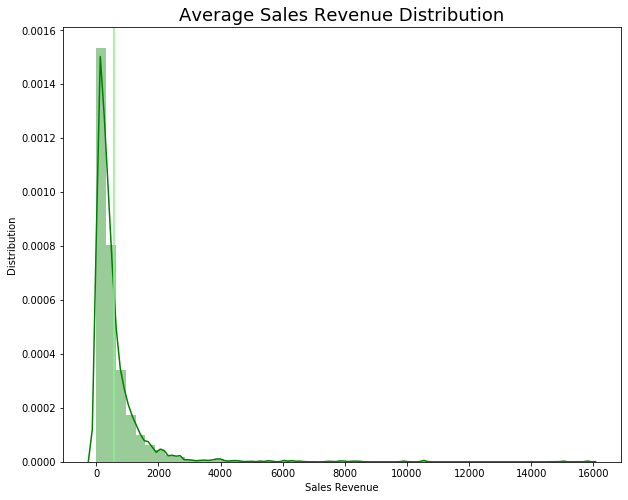

In [100]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(dfr['SaleRev'], color='green')
plt.axvline(avrev, color='lightgreen' )
plt.xlabel('Sales Revenue')
plt.ylabel('Distribution')
plt.title('Average Sales Revenue Distribution', fontsize=18)
plt.show()

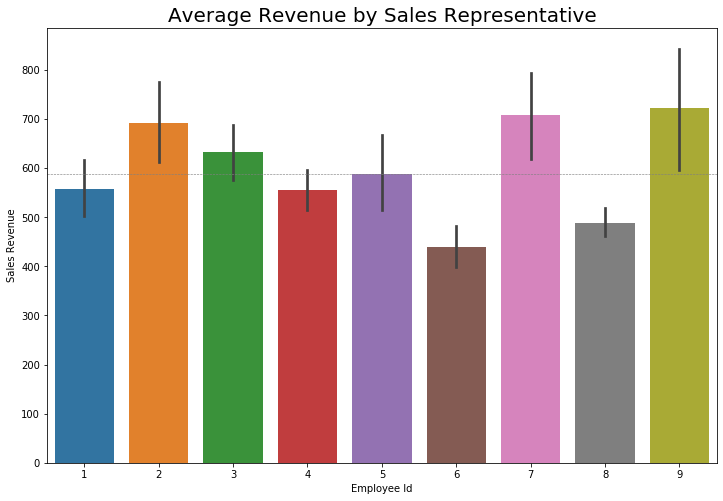

In [101]:
##is there a way to sort this???
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=dfr, x='EmployeeId', y='SaleRev', ci=68, ax=ax)
plt.title('Average Revenue by Sales Representative', fontsize=20)
plt.axhline(avrev,linestyle="--", color='gray', linewidth=.6 )
plt.xlabel('Employee Id')
plt.ylabel('Sales Revenue')
plt.show()


Employees are listed in the table below:
Although the employee names are unique, for the sake of data inspection we'll continue to use Employee Id as the unique identifier and reference the table above to gather additional insight.

In [102]:
cur.execute("""SELECT ID, LastName, FirstName, Title, Region
                from Employee""")
empsdata = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
empsdata

,Id,LastName,FirstName,Title,Region
0,1,Davolio,Nancy,Sales Representative,North America
1,2,Fuller,Andrew,"Vice President, Sales",North America
2,3,Leverling,Janet,Sales Representative,North America
3,4,Peacock,Margaret,Sales Representative,North America
4,5,Buchanan,Steven,Sales Manager,British Isles
5,6,Suyama,Michael,Sales Representative,British Isles
6,7,King,Robert,Sales Representative,British Isles
7,8,Callahan,Laura,Inside Sales Coordinator,North America
8,9,Dodsworth,Anne,Sales Representative,British Isles


In [103]:
reps = {}
for rep in dfr['EmployeeId'].unique():
    reps[rep] = dfr.groupby('EmployeeId').get_group(rep)['SaleRev']


Distributions appear roughly equal


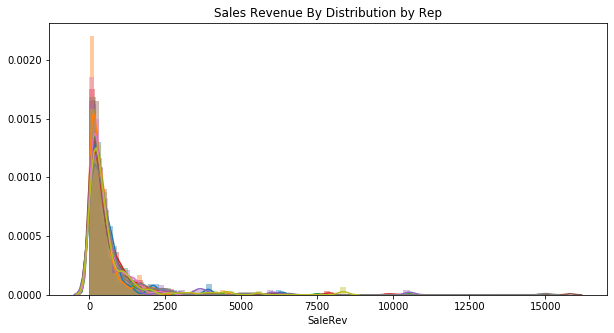

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in reps.items():
    sns.distplot(v,label=v)

plt.title('Sales Revenue By Distribution by Rep')
print('Distributions appear roughly equal')

#### Initial Observations:
Datatype is numeric in this 2155 order sample.

There are 9 employees in this company associated with sales information

The avarage revenue generated by a sales representative is $629.00. 

Initial visual inspection indicates roughly uniform distribution in sales revenue, more than half of the sales representatives achieve the average.  Additional testing will demonstrate if it is significant.

Since we are comparing multiple discounts to inspect it's impact on quantity ordered an AVNOVA test will be run:
Assumptions for ANOVA Testing: 

1) No significant outliers 
    Upon a quick visual inspection, there appears to be some outliers that could be removed

2) Equal variance
    


3) Normality (if n>15)
      Not required for samples greater than 15

### Assumption 1: Outliers

In [105]:
for rep, rep_data in reps.items():
    idx_outs = fn.find_outliers_Z(rep_data)
    print(f'Found {idx_outs.sum()} outliers in Employee # {rep}')
    reps[rep] = rep_data[~idx_outs]
print('\n All of these outliers were removed')



Found 3 outliers in Employee # 5
Found 3 outliers in Employee # 6
Found 7 outliers in Employee # 4
Found 4 outliers in Employee # 3
Found 2 outliers in Employee # 9
Found 4 outliers in Employee # 1
Found 5 outliers in Employee # 8
Found 5 outliers in Employee # 2
Found 5 outliers in Employee # 7

 All of these outliers were removed


###  Asumption 2: Equal Variance

Results are NOT equal variance for this group

In [106]:
#from functions import test_equal_variance
import scipy.stats as stats

In [107]:
data = []
for k,v in reps.items():
    data.append(v)
    

In [108]:
stat,p = stats.levene(*data)
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')
      
          

Lavene test for equal variance results are 0.0143
The groups do NOT have equal variance


### Assumption 3:  Normality
The lengths of these samples are >15 so normality criteria is met.

In [109]:
n = []

for rep,samples in reps.items():
    print(f'There are {len(samples)} samples in the data set for Employee #{rep}.')
    n.append(len(samples)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')
    





There are 114 samples in the data set for Employee #5.
There are 165 samples in the data set for Employee #6.
There are 413 samples in the data set for Employee #4.
There are 317 samples in the data set for Employee #3.
There are 105 samples in the data set for Employee #9.
There are 341 samples in the data set for Employee #1.
There are 255 samples in the data set for Employee #8.
There are 236 samples in the data set for Employee #2.
There are 171 samples in the data set for Employee #7.

All samples are >15: Normality Assumption Criterion is met.


# HELP: Using non-parametric Kruskal since the data set was not of equal variance AND Possible Cohen_f here possibly t-test since tukey isn't showing significant differences.

In [110]:
stat, p = stats.kruskal(*data)
print(f"Kruskal test p value: {round(p,4)}")

Kruskal test p value: 0.2968


In [111]:
stat, p = stats.f_oneway(*data)
print(stat,p)

2.180626766904163 0.026222185205141618


In [112]:
def prep_data_for_tukeys(reps):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 

    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 

    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()"""
        
    import pandas as pd
    df_tukey = pd.DataFrame(columns=['data','group'])
    for k,v in  reps.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey,grp_df],axis=0)
    return df_tukey

In [113]:
clean_data = prep_data_for_tukeys(reps)
clean_data

,data,group
0,168.000,5
1,98.000,5
2,174.000,5
17,45.900,5
18,342.720,5
...,...,...
2077,390.000,7
2103,52.350,7
2104,386.400,7
2105,490.000,7


### Hypothesis 3: A Clean Visualization:

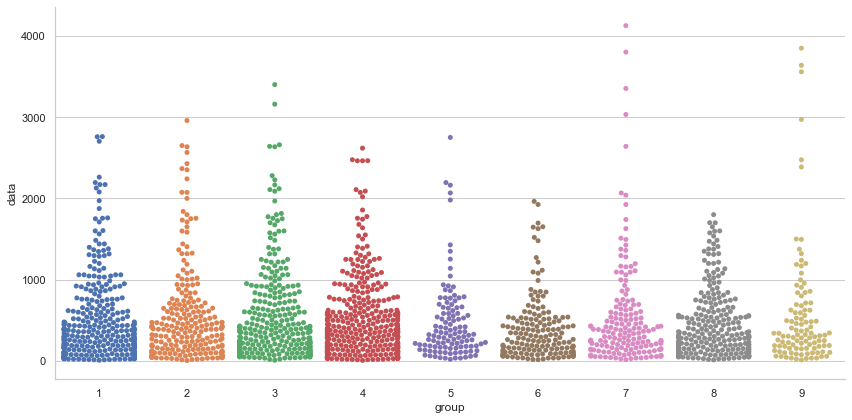

In [159]:

sns.catplot(data=clean_data, x='group', y='data', kind='swarm', height=6, aspect=2)

Text(0.5, 1.0, 'Average Revenue Generated by Sales Representative')

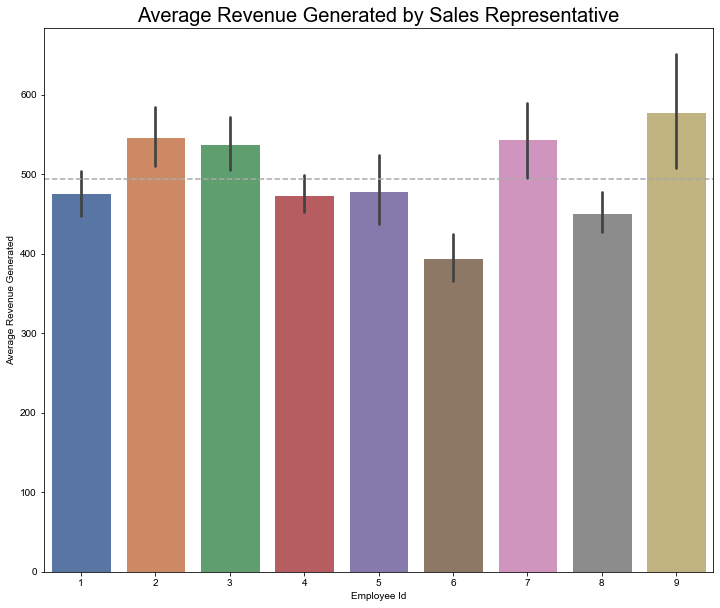

In [114]:
f, ax = plt.subplots(figsize=(12,10))
sns.set(style="whitegrid")
sns.barplot(data=clean_data, x='group', y='data', ci=68)
plt.xlabel('Employee Id')
plt.ylabel('Average Revenue Generated')
plt.axhline(clean_data['data'].mean(), linestyle="--", color='darkgray')

plt.title('Average Revenue Generated by Sales Representative', fontsize=20)


In [115]:
clean_data['data'] = clean_data['data'].astype(float)
clean_data['group'] = clean_data['group'].astype(str)

In [116]:
clean_data

,data,group
0,168.000,5
1,98.000,5
2,174.000,5
17,45.900,5
18,342.720,5
...,...,...
2077,390.000,7
2103,52.350,7
2104,386.400,7
2105,490.000,7


In [83]:
## run t-test manually to look deeper

In [117]:
tukey = sms.stats.multicomp.pairwise_tukeyhsd(clean_data['data'], clean_data['group'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,70.6795,0.7896,-67.9146,209.2736,False
1,3,62.1979,0.8328,-65.5036,189.8995,False
1,4,-2.0207,0.9,-121.7839,117.7426,False
1,5,2.7041,0.9,-174.3746,179.7827,False
1,6,-81.4678,0.7616,-236.6872,73.7517,False
1,7,68.5247,0.9,-84.8486,221.8981,False
1,8,-24.7293,0.9,-160.2376,110.779,False
1,9,101.7408,0.7013,-80.9369,284.4186,False
2,3,-8.4815,0.9,-149.2052,132.2421,False
2,4,-72.7002,0.725,-206.2617,60.8614,False


### Effect Size Testing:

In [85]:
nine = clean_data.groupby('group').get_group('9.0')
eight = clean_data.groupby('group').get_group('8.0')
seven =clean_data.groupby('group').get_group('7.0')
six = clean_data.groupby('group').get_group('6.0')
five =clean_data.groupby('group').get_group('5.0')
four = clean_data.groupby('group').get_group('4.0')
three = clean_data.groupby('group').get_group('3.0')
two = clean_data.groupby('group').get_group('2.0')
one = clean_data.groupby('group').get_group('1.0')


fn.Cohen_d(clean_data['data'], nine)

KeyError: '9.0'

In [ ]:
fn.Cohen_d(clean_data['data'], eight)

In [ ]:
fn.Cohen_d(clean_data['data'], seven)

In [ ]:
fn.Cohen_d(clean_data['data'], six)

In [ ]:
fn.Cohen_d(clean_data['data'], five)

In [ ]:
fn.Cohen_d(clean_data['data'], four)

In [ ]:
fn.Cohen_d(clean_data['data'], three)

In [ ]:
fn.Cohen_d(clean_data['data'], two)

In [ ]:
fn.Cohen_d(clean_data['data'], one)

### Observations and recommendations: 
    Not sure that I agree with these results based on visual inspetion of data, perhaps testing was inaccurate???
    
    If there is no statistical difference, and effect size is small at best, best practices can still be shared by those who have a higher average revenue, examples 2,3 and 9 still have higher than average sales.
    
    Since no one is currently "top dog", perhaps a little healthy, insentivised competition might spur increased revenues if not by one, by many.  Also, remind sales teams that the lower discounts have demonstrated greater quantities sold.
   
    

# HYPOTHESIS 4:

> ***Where are our customers from that spend the most money?***

$H0$: Customers spend equal amounts regardless of region.

$H1$: Region has an effect on total amount spent.


    

#### Importing and inspecting data from  OrderDetail and Order

These table includes information on:

    1) Sales total information 
    2) Regions where orders shipped to indicating the location of customers

In [118]:
cur.execute("""SELECT 
                ShipRegion, 
                OrderID, 
                ProductID, 
                UnitPrice,
                Quantity, 
                Discount
                FROM `Order` AS o
                JOIN OrderDetail AS od
                on o.ID = od.OrderId ;""")
dfreg = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
dfreg.head()

,ShipRegion,OrderId,ProductId,UnitPrice,Quantity,Discount
0,Western Europe,10248,11,14.0,12,0.0
1,Western Europe,10248,42,9.8,10,0.0
2,Western Europe,10248,72,34.8,5,0.0
3,Western Europe,10249,14,18.6,9,0.0
4,Western Europe,10249,51,42.4,40,0.0


In [120]:
dfreg['TotalSpend'] = ((dfreg['UnitPrice'])*(1 - dfreg['Discount']))*dfreg['Quantity']

### Hypothesis 4 Preliminary Visualizations:

The average total spend is $587.37


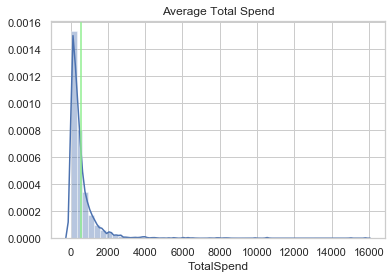

In [121]:
fig, ax = plt.subplots()
spend_mu = dfreg['TotalSpend'].mean()
sns.distplot(dfreg['TotalSpend'], ax=ax)
plt.axvline(spend_mu, color='lightgreen')
plt.title('Average Total Spend')
print(f'The average total spend is ${round(spend_mu,2)}')

In [122]:
regs = {}
for reg in dfreg['ShipRegion'].unique():
    regs[reg] = dfreg.groupby('ShipRegion').get_group(reg)['TotalSpend']


In [123]:
regions = list(dfreg['ShipRegion'].unique())
regions
print(f'There are {len(regions)} regions.')

There are 9 regions.


Distributions appear roughly equal


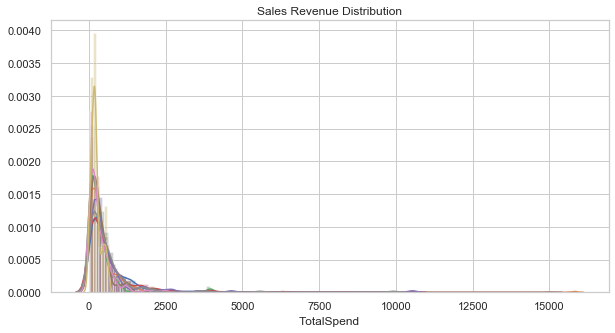

In [124]:
fig, ax = plt.subplots(figsize=(10,5))
for k,v in regs.items():
    sns.distplot(v,label=v)


plt.title('Sales Revenue Distribution')
print('Distributions appear roughly equal')

In [125]:
@interact
def plt_discounts(d=regions):
    sns.distplot(dfreg.groupby('ShipRegion').get_group(d)['TotalSpend'])
    plt.axvline(spend_mu, color='purple')
    plt.gca()

interactive(children=(Dropdown(description='d', options=('Western Europe', 'South America', 'Central America',…

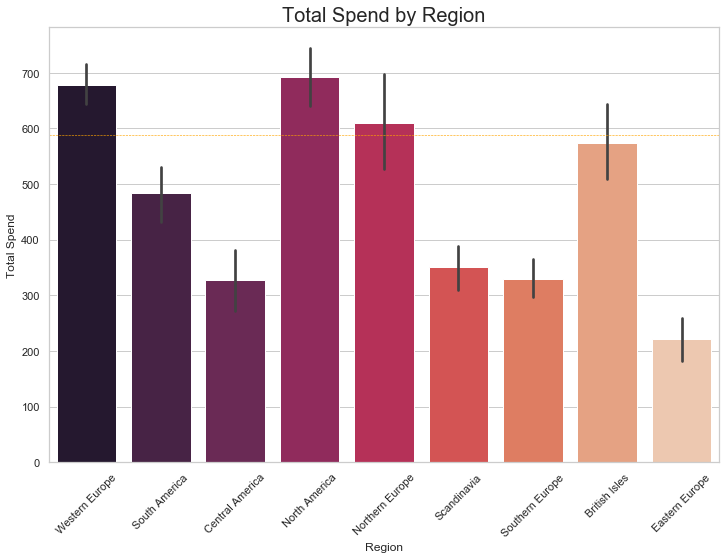

In [126]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=dfreg, x='ShipRegion', y='TotalSpend', ci=68, palette="rocket", ax=ax)
plt.title('Total Spend by Region', fontsize=20)
plt.axhline(spend_mu,linestyle="--", color='orange', linewidth=.6 )
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Total Spend')
plt.show()

#### Hypothesis 4 Initial Observations:
Datatype is numeric in this 2155 order sample.

There are 9 regions in reflected in this dataset

The avarage of total spent is $587.37.

Initial visual inspection indicates skewed, but roughly uniform distribution in total sales, more than half of the sales representatives achieve the average. Additional testing will demonstrate if it is significant.

Since we are comparing multiple regions to inspect it's impact on quantity ordered an AVNOVA test will be run: Assumptions for ANOVA Testing:

1) Upon a quick visual inspection, there appears to be some outliers that could be removed

2) Equal variance

3) Normality (if n>15) Not required for samples greater than 15

### Hypothesis 4 Assumption 1: Outlier 
Outliers were identified and removed via z-score testing.  Details are below:

In [127]:
regs = {}
for reg in dfreg['ShipRegion'].unique():
    regs[reg] = dfreg.groupby('ShipRegion').get_group(reg)['TotalSpend']


In [128]:
for reg, reg_data in regs.items():
    idx_outs = fn.find_outliers_Z(reg_data)
    print(f'Found {idx_outs.sum()} outliers in the {reg}')
    regs[reg] = reg_data[~idx_outs]
print('\n All of these outliers were removed')

Found 11 outliers in the Western Europe
Found 2 outliers in the South America
Found 1 outliers in the Central America
Found 9 outliers in the North America
Found 2 outliers in the Northern Europe
Found 1 outliers in the Scandinavia
Found 3 outliers in the Southern Europe
Found 4 outliers in the British Isles
Found 0 outliers in the Eastern Europe

 All of these outliers were removed


### Hypothesis 4 Assumption 2: Equal Variance

In [129]:
data = []
labels = []
for k,v in regs.items():
    data.append(v)
    labels.append(k)

In [130]:
stat,p = stats.levene(*data, center = 'median')
print(f'Lavene test for equal variance results are {round(p,4)}')
sig = 'do NOT' if p < .05 else 'DO'

print(f'The groups {sig} have equal variance')
      

Lavene test for equal variance results are 0.0
The groups do NOT have equal variance


### Hypothesis 4 Assumption 3: Normality

In [131]:
n =[]
for reg, samples in regs.items():
    print(f'There are {len(samples)} samples in the data set for Regions #{reg}.')
    n.append(len(samples)>15)
if all(n):
    print('\nAll samples are >15: Normality Assumption Criterion is met.')

There are 734 samples in the data set for Regions #Western Europe.
There are 353 samples in the data set for Regions #South America.
There are 71 samples in the data set for Regions #Central America.
There are 418 samples in the data set for Regions #North America.
There are 141 samples in the data set for Regions #Northern Europe.
There are 69 samples in the data set for Regions #Scandinavia.
There are 134 samples in the data set for Regions #Southern Europe.
There are 186 samples in the data set for Regions #British Isles.
There are 16 samples in the data set for Regions #Eastern Europe.

All samples are >15: Normality Assumption Criterion is met.


#### Using non-parametric Kruskal since the data set was not of equal variance:

In [132]:
stat, p = stats.kruskal(*data)
print(f"Kruskal test p value: {round(p,6)}")

Kruskal test p value: 0.0


# HELP: Post-Hoc Testing Cohen_f??


In [133]:
cregs = fn.prep_data_for_tukeys(regs)  
cregs

,data,group
0,168.0,Western Europe
1,98.0,Western Europe
2,174.0,Western Europe
3,167.4,Western Europe
4,1696.0,Western Europe
...,...,...
1933,54.0,Eastern Europe
1934,199.5,Eastern Europe
1935,200.0,Eastern Europe
1936,232.5,Eastern Europe


In [134]:
cregs['data']=cregs['data'].astype(float)
cregs['group']=cregs['group'].astype(str)

In [135]:
tukey = sms.stats.multicomp.pairwise_tukeyhsd(cregs['data'],cregs['group'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
British Isles,Central America,-185.8522,0.2271,-415.6671,43.9628,False
British Isles,Eastern Europe,-241.5782,0.6901,-670.7752,187.6188,False
British Isles,North America,108.0077,0.3368,-37.1939,253.2093,False
British Isles,Northern Europe,48.1291,0.9,-135.8232,232.0814,False
British Isles,Scandinavia,-137.1482,0.6379,-369.3612,95.0647,False
British Isles,South America,-38.1848,0.9,-187.4464,111.0767,False
British Isles,Southern Europe,-172.9738,0.0946,-359.6391,13.6914,False
British Isles,Western Europe,124.6055,0.0989,-10.6288,259.8398,False
Central America,Eastern Europe,-55.726,0.9,-511.6242,400.1721,False
Central America,North America,293.8599,0.001,82.3968,505.3229,True


### Hypothesis 4 Observations and Recommendations:

#### Obeservations 
The average spend for this dataset was $500.

The p value for the kruskal test was singificant, which can reject the null hypothesis that all regions spend the same amounts. 

Orders shipped to Western Europe, and North America and Northern Europe generated the highest amount of revenue, statistically these regions are equal.  







This is true in comparison over
Central America, 



#### Recommendations:
Ensure that products are stocked and available in regions and focus marketing and sales training in areas that need to be developed.


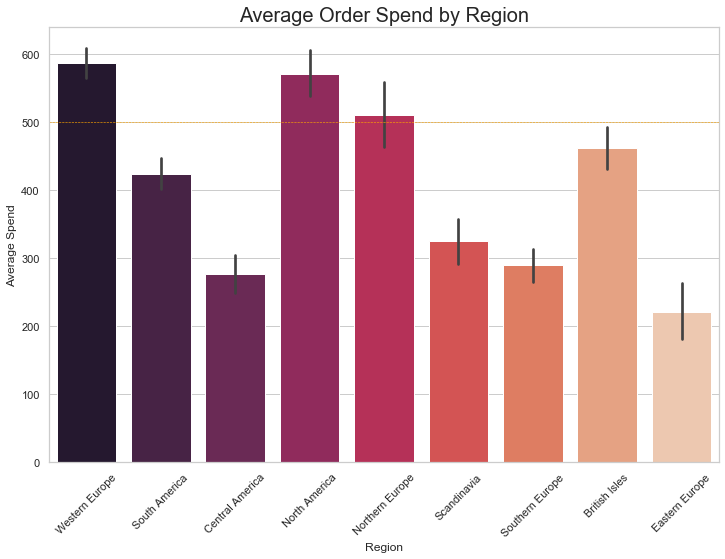

In [136]:
avspend = cregs['data'].mean()
avspend
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=cregs, x='group', y='data', ci=68, palette="rocket", ax=ax)
plt.title('Average Order Spend by Region', fontsize=20)
plt.axhline(avspend,linestyle="--", color='orange', linewidth=.6 )
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Average Spend')
plt.show()

In [104]:
avspend

500.12534142318566